In [300]:
%load_ext autoreload
%autoreload 2

import os
from itertools import count

import contextily as cx
import geopandas
import matplotlib.pyplot as plt
import momepy
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import shapely
import shapefile
import seaborn as sns

from tqdm.auto import tqdm
from libpysal.cg import voronoi_frames

sns.set_theme(context='poster', style="whitegrid")
shapely.speedups.disable()

DATA = "data"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dane z SIPW

In [176]:
df = geopandas.read_file("data/TrasyRowerowe/TrasyRowerowe.dbf")
df = df[df['geometry'].notna()]
types_to_remove = ['łącznik drogowy', 'strefa ruchu uspokojonego 20 i 30 km/h']
df = df[~df.TYP.isin(types_to_remove)]
df = df.to_crs("epsg:4326")

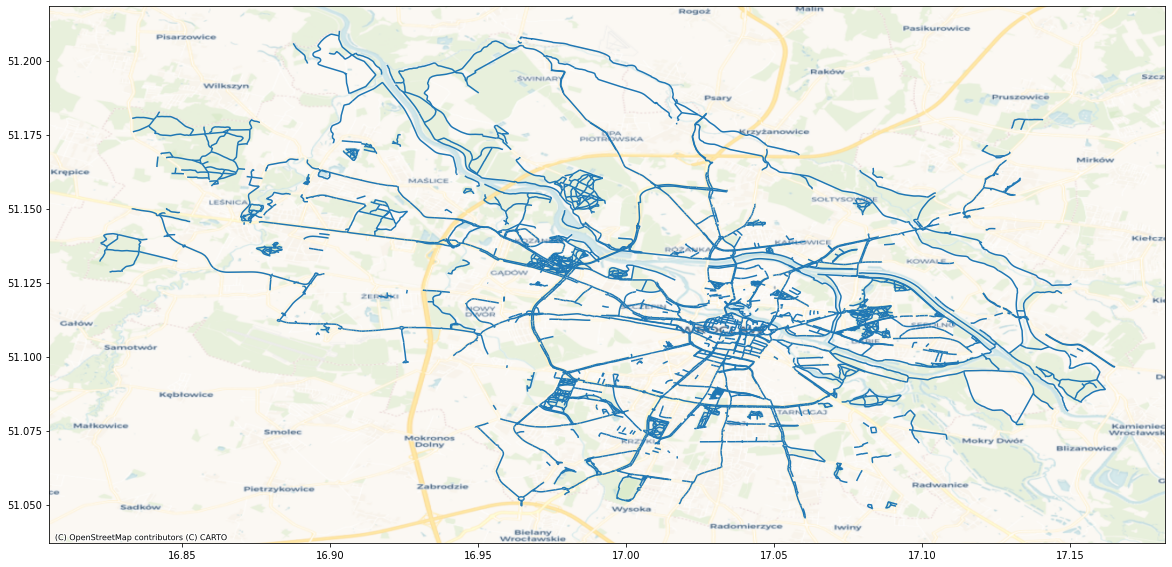

In [177]:
fig = plt.figure(figsize=(20, 20))
ax = plt.subplot()
df.plot(ax=ax)
cx.add_basemap(ax, crs=df.crs, source=cx.providers.CartoDB.Voyager)

In [178]:
df

TYP  KIERUNEK   SHAPE_LEN  \
0      droga dla pieszych i rowerów       2.0    3.435021   
1      droga dla pieszych i rowerów       2.0   10.438371   
2      droga dla pieszych i rowerów       2.0   33.520372   
3                 droga dla rowerów       2.0  161.448060   
4                 droga dla rowerów       2.0   94.881983   
...                             ...       ...         ...   
15799           możliwość przejazdu       1.0   11.995666   
15800         pas ruchu dla rowerów       1.0    9.154817   
15803         pas ruchu dla rowerów       1.0  104.677264   
15804           możliwość przejazdu       1.0   14.395840   
15805         pas ruchu dla rowerów       1.0    4.126849   

                                                geometry  
0      LINESTRING (17.05105 51.10553, 17.05110 51.10552)  
1      LINESTRING (17.04653 51.10892, 17.04654 51.10883)  
2      LINESTRING (17.04654 51.10883, 17.04654 51.108...  
3      LINESTRING (17.04657 51.11170, 17.04647 51.111...  
4      LINESTRING (17.04439 51.11201, 17.04426 51.111...  
...                                                  ...  
15799  LINESTRING (17.04091 51.10901, 17.04105 51.10907)  
15800  LINESTRING (17.04142 51.10909, 17.04142 51.109...  
15803  LINESTRING (17.03897 51.10822, 17.03895 51.108...  
15804  LINESTRING (17.03908 51.10908, 17.03923 51.10899)  
15805  LINESTRING (17.03917 51.10899, 17.03923 51.10899)  

[8249 rows x 4 columns]

In [152]:
spiw_graph = momepy.gdf_to_nx(df, approach='primal')

c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\momepy\utils.py:235: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


In [153]:
len(spiw_graph)

6980

In [154]:
for i, n in enumerate(spiw_graph.nodes):
    spiw_graph.nodes[n]["x"]=n[0]
    spiw_graph.nodes[n]["y"]=n[1]
    spiw_graph.nodes[n]["type"]='city_crossing'
    
spiw_graph = nx.relabel.convert_node_labels_to_integers(spiw_graph, 1000000)

In [155]:
points, lines = momepy.nx_to_gdf(spiw_graph)

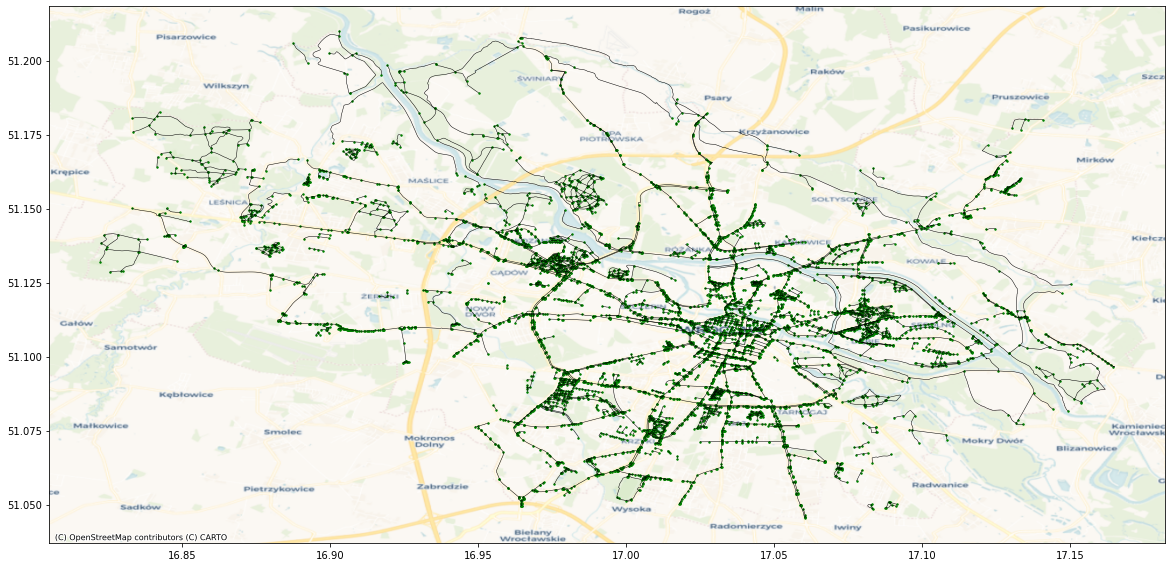

In [159]:
fig = plt.figure(figsize=(20,20))
ax = plt.subplot()

points.plot(markersize=2, color='green', ax=ax)
lines.plot(ax=ax, alpha=1, linewidth=0.5, edgecolor='k')
cx.add_basemap(ax=ax, crs=points.crs.to_string(), source=cx.providers.CartoDB.Voyager)

# Dane z OSM

In [150]:
def plot_graph(graph):
    G_nodes, G_streets = ox.graph_to_gdfs(graph)

    G_nodes = G_nodes.to_crs(epsg=2177)
    G_streets = G_streets.to_crs(epsg=2177)

    fig = plt.figure(figsize=(20,20))
    ax = plt.subplot()

    G_nodes.plot(markersize=5, color='green', ax=ax)
    G_streets.plot(ax=ax, alpha=1, linewidth=0.5, edgecolor='k')
    cx.add_basemap(ax=ax, crs=G_nodes.crs.to_string(), source=cx.providers.CartoDB.Voyager)

In [99]:
# Wrocław coordinates
latitude = 51.11
longitude =  17.022222

max_dist_km = 18
max_dist = max_dist_km * 1000


custom_filter_list = [
    '["highway"~"cycleway"]',
    '["cycleway"~"lane"]',
    '["cycleway"~"shared_lane"]',
    '["highway"~"pedestrian"]["bicycle"~"yes"]',
    '["highway"~"path"]["bicycle"~"yes"]',
    '["highway"~"track"]["bicycle"~"yes"]'
]

peripheral_graph_list = [ox.graph_from_point((latitude, longitude), dist=max_dist, retain_all=True, custom_filter=cf)
              for cf in custom_filter_list]


c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\

In [100]:
G = peripheral_graph_list[0]
for i in range(1, len(peripheral_graph_list)):
    G = nx.compose(G, peripheral_graph_list[i])

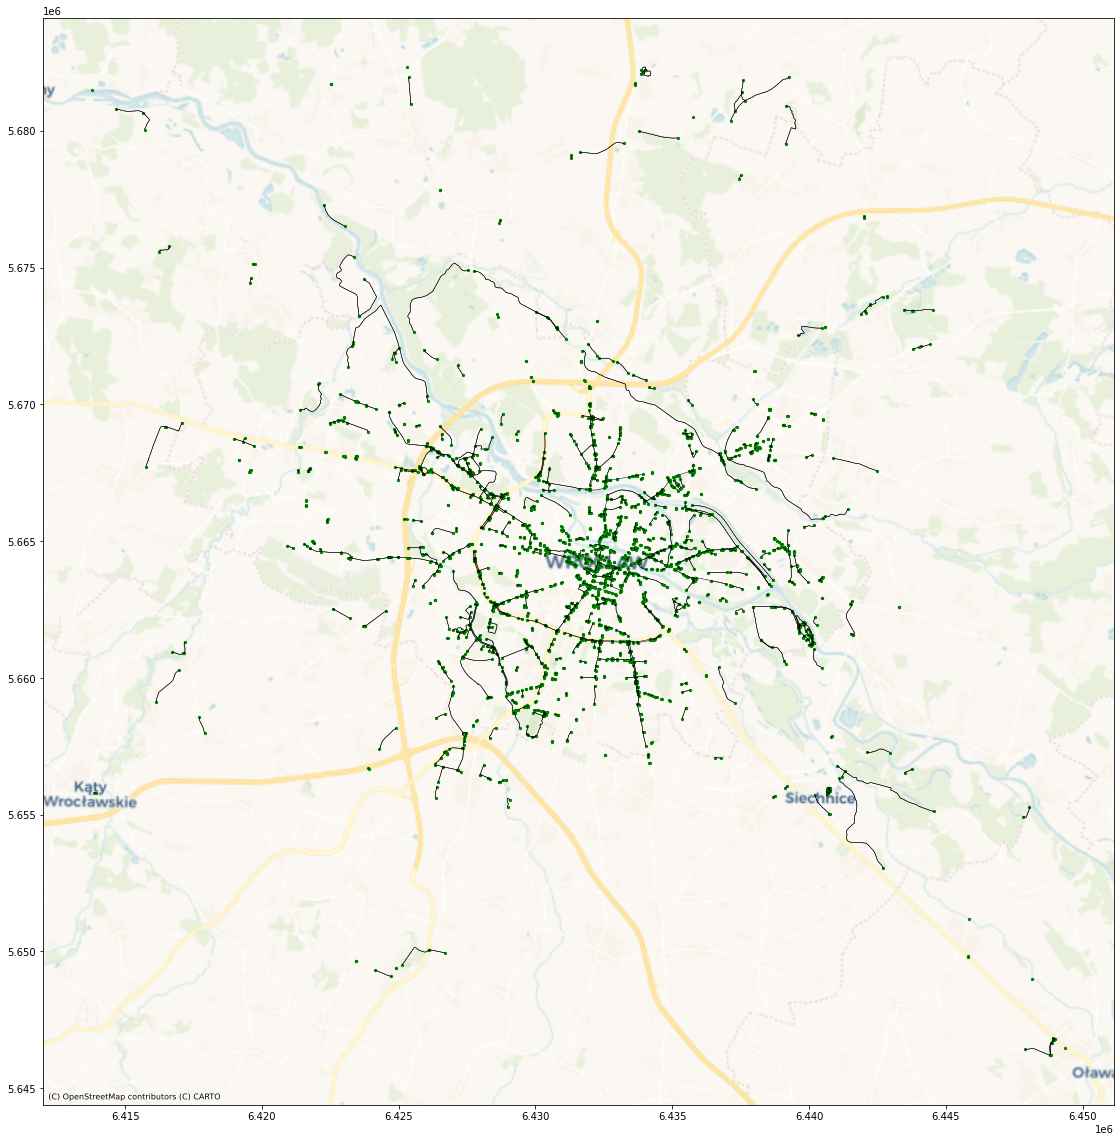

In [101]:
plot_graph(G)

In [107]:
wroclaw_graph_list = [ox.graph_from_place('Wroclaw, Poland', retain_all=True, custom_filter=cf)
                      for cf in custom_filter_list]

G_wroclaw = wroclaw_graph_list[0]
for i in range(1, len(wroclaw_graph_list)):
    G_wroclaw = nx.compose(G_wroclaw, wroclaw_graph_list[i])

c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\

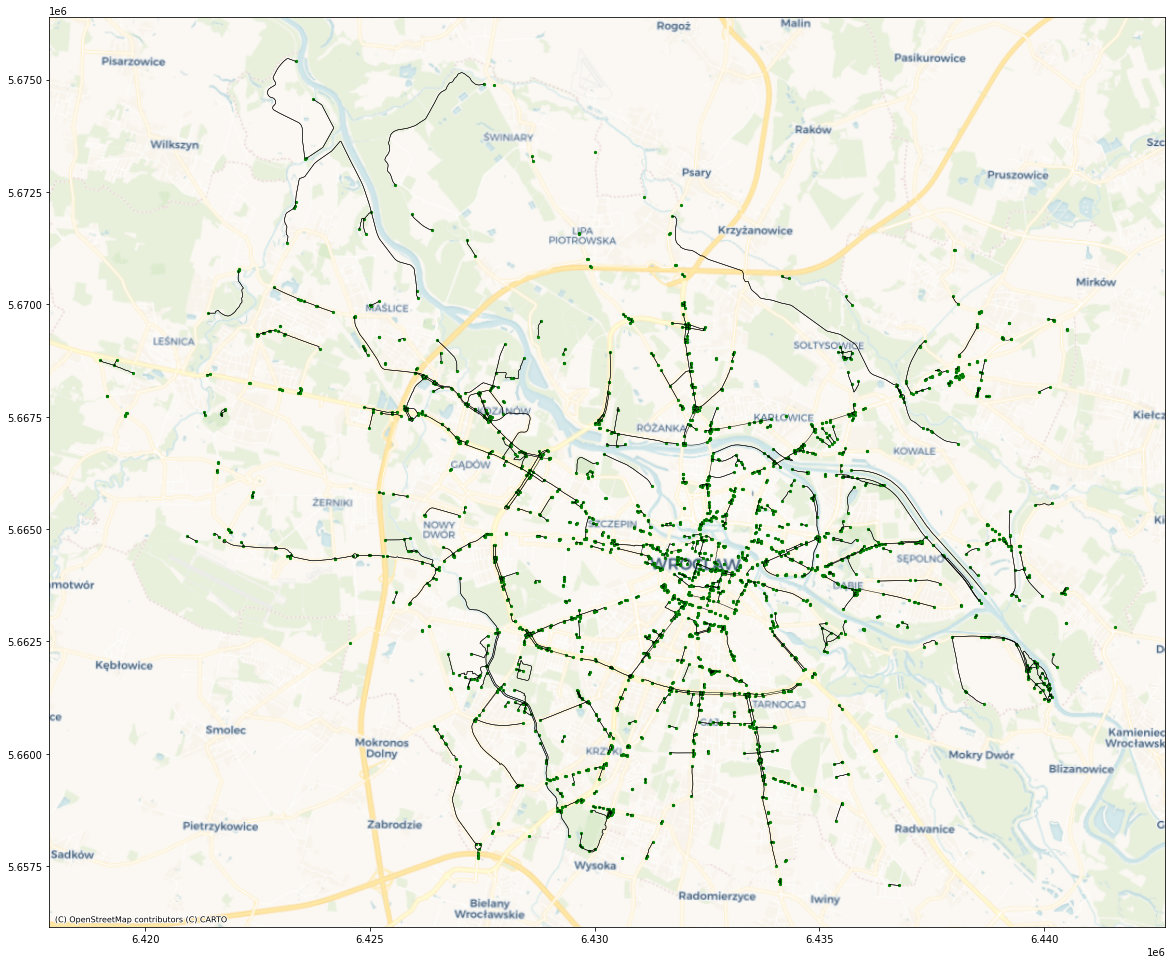

In [108]:
plot_graph(G_wroclaw)

Usunięcie dróg wewnątrz granic Wrocławia

In [122]:
G_without_wroc = G.copy()

In [128]:
for n in G_wroclaw.nodes:
    G_without_wroc.remove_node(n)

In [165]:
for i, n in enumerate(G_without_wroc.nodes):
    G_without_wroc.nodes[n]["type"]='peripheral_crossing'

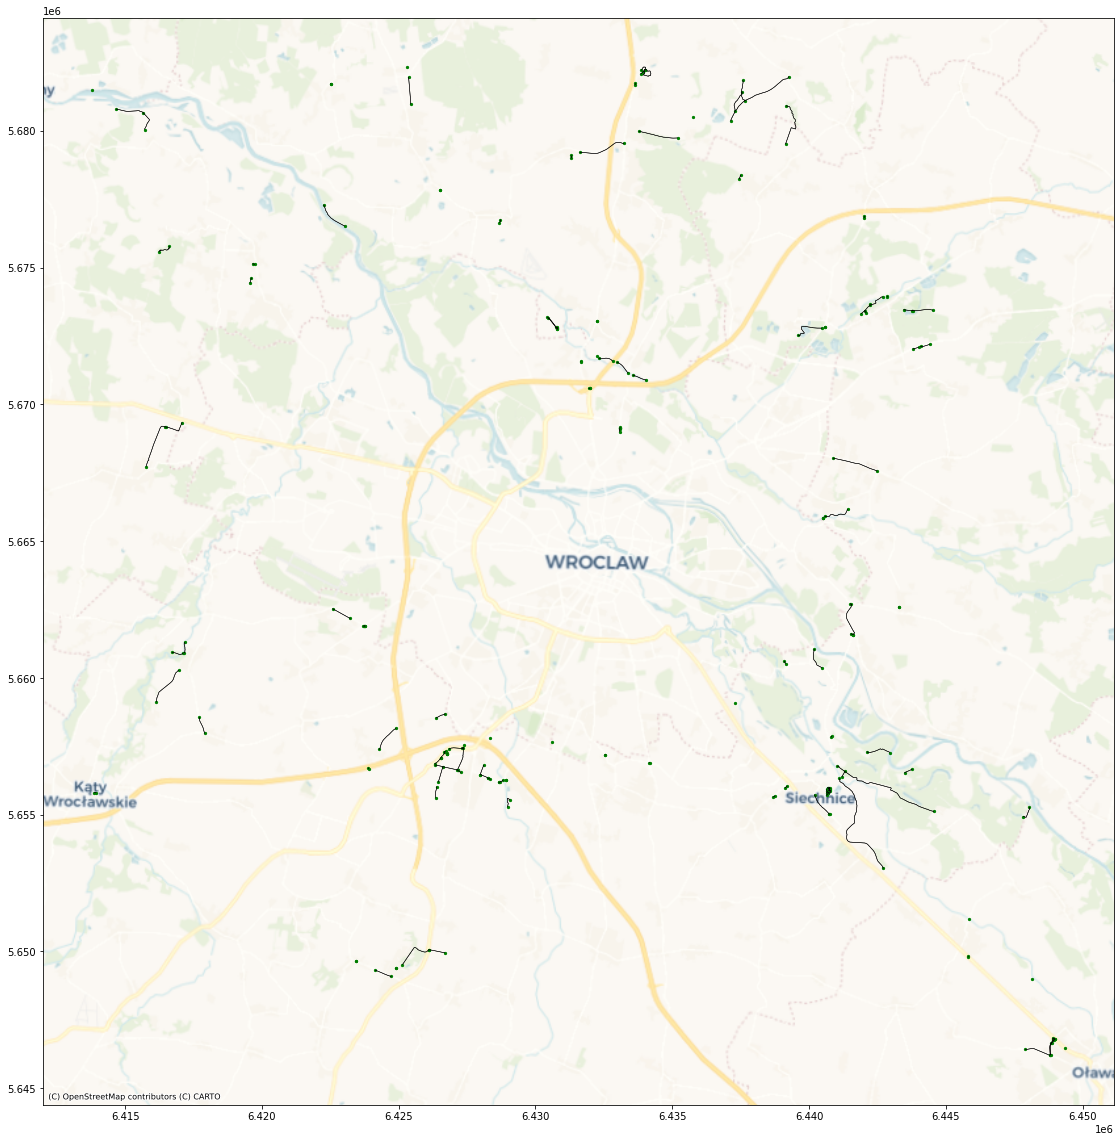

In [166]:
plot_graph(G_without_wroc)

# Połączenie grafów OSM i SPIW

In [167]:
G_without_wroc.nodes[371217955]

{'y': 51.0434054,
 'x': 17.0610248,
 'street_count': 1,
 'type': 'peripheral_crossing'}

In [173]:
G_without_wroc[371217955][5000615166]

AtlasView({0: {'osmid': [571461165, 571461166, 511147188, 511147190, 511147191], 'highway': 'cycleway', 'oneway': False, 'length': 26.086000000000002, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001FBDCB41828>}})

In [169]:
spiw_graph.nodes[1000000]

{'x': 17.05105179721908,
 'y': 51.10552573556749,
 'type': 'city_crossing',
 'nodeID': 0}

In [175]:
spiw_graph[1000000][1000001]

AtlasView({0: {'TYP': 'droga dla pieszych i rowerów', 'KIERUNEK': 2.0, 'SHAPE_LEN': 3.43502060693, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001FBE3E3C4A8>, 'mm_len': 4.9018247839862264e-05}})

In [179]:
G_entire = nx.compose(G_without_wroc, spiw_graph)

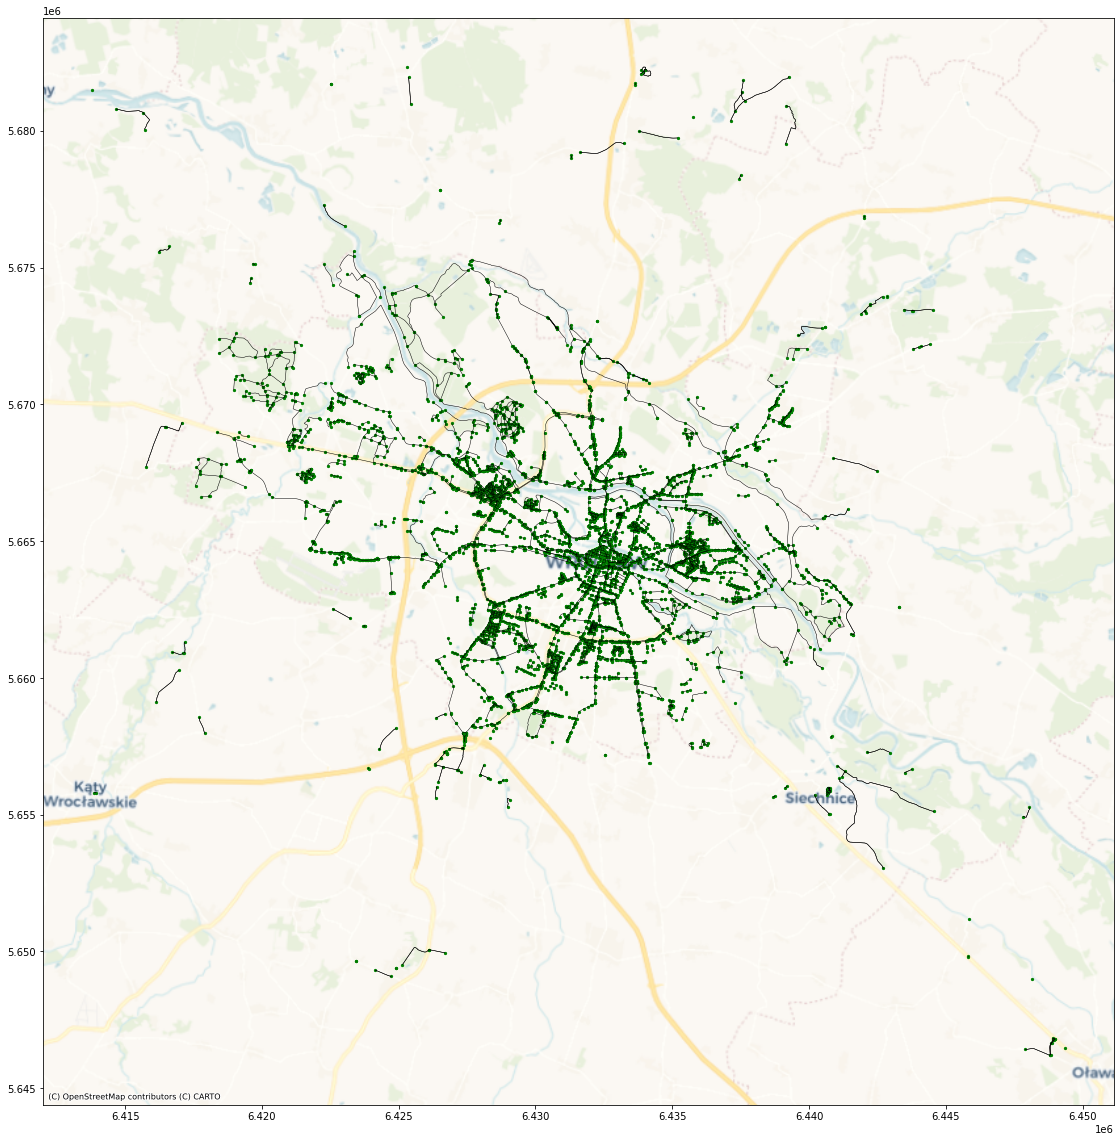

In [182]:
plot_graph(G_entire)

In [196]:
nx.write_gpickle(G_entire, os.path.join(DATA, "graph_entire.gpickle"))

# Połączenie z investamapą

In [252]:
G_entire = nx.read_gpickle(os.path.join(DATA, "graph_entire.gpickle"))

nx.set_edge_attributes(G_entire, "bicycle_path", "type")

nodes_gdf, lines_gdf = ox.graph_to_gdfs(G_entire)
nodes_gdf = nodes_gdf.to_crs(epsg=4326)

In [253]:
investmap_gdf = geopandas.read_file(os.path.join(DATA, "investmap.csv"))
investmap_gdf["Longitude"] = investmap_gdf["Longitude"].apply(lambda x: float(x))
investmap_gdf["Latitude"] = investmap_gdf["Latitude"].apply(lambda x: float(x))
investmap_gdf["geometry"] = geopandas.points_from_xy(investmap_gdf["Longitude"], investmap_gdf["Latitude"])
investmap_gdf = investmap_gdf.set_crs(epsg=4326)

c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [254]:
x_min = nodes_gdf.x.min()
x_max = nodes_gdf.x.max()
y_min = nodes_gdf.y.min()
y_max = nodes_gdf.y.max()
x_min, x_max, y_min, y_max

(16.7646037, 17.2792666, 50.9487459, 51.2711177)

In [255]:
investmap_gdf = investmap_gdf[(x_min < investmap_gdf.Longitude) & (investmap_gdf.Longitude < x_max) &
                              (y_min < investmap_gdf.Latitude) & (investmap_gdf.Latitude < y_max)]

In [256]:
len(investmap_gdf)

1480

In [257]:
i = investmap_gdf.to_crs(epsg=2177) #Poland epsg
b = nodes_gdf.to_crs(epsg=2177)

In [258]:
for j, (p_ind, p) in tqdm(enumerate(i.iterrows()), total=i.shape[0]):
    distance=b.distance(p["geometry"])
    idx = distance.idxmin()
    min_d = distance.min()
    node = f'{p["Id"]}_building'
    G_entire.add_nodes_from([(node, {'type': 'building', 'name': p["Title"], 'y': p["Latitude"], 'x': p["Longitude"]})])
    G_entire.add_edge(idx, node, length=min_d, type="closest_crossing")

  0%|          | 0/1480 [00:00<?, ?it/s]

In [259]:
nx.write_gpickle(G_entire, os.path.join(DATA, "entire_with_investmap.gpickle"))

### Wizualizacja

In [271]:
G = nx.read_gpickle(os.path.join(DATA, "entire_with_investmap.gpickle"))

In [272]:
G_nodes, G_edges = ox.graph_to_gdfs(G)
G_nodes = G_nodes.to_crs(epsg=2177)
G_edges = G_edges.to_crs(epsg=2177)

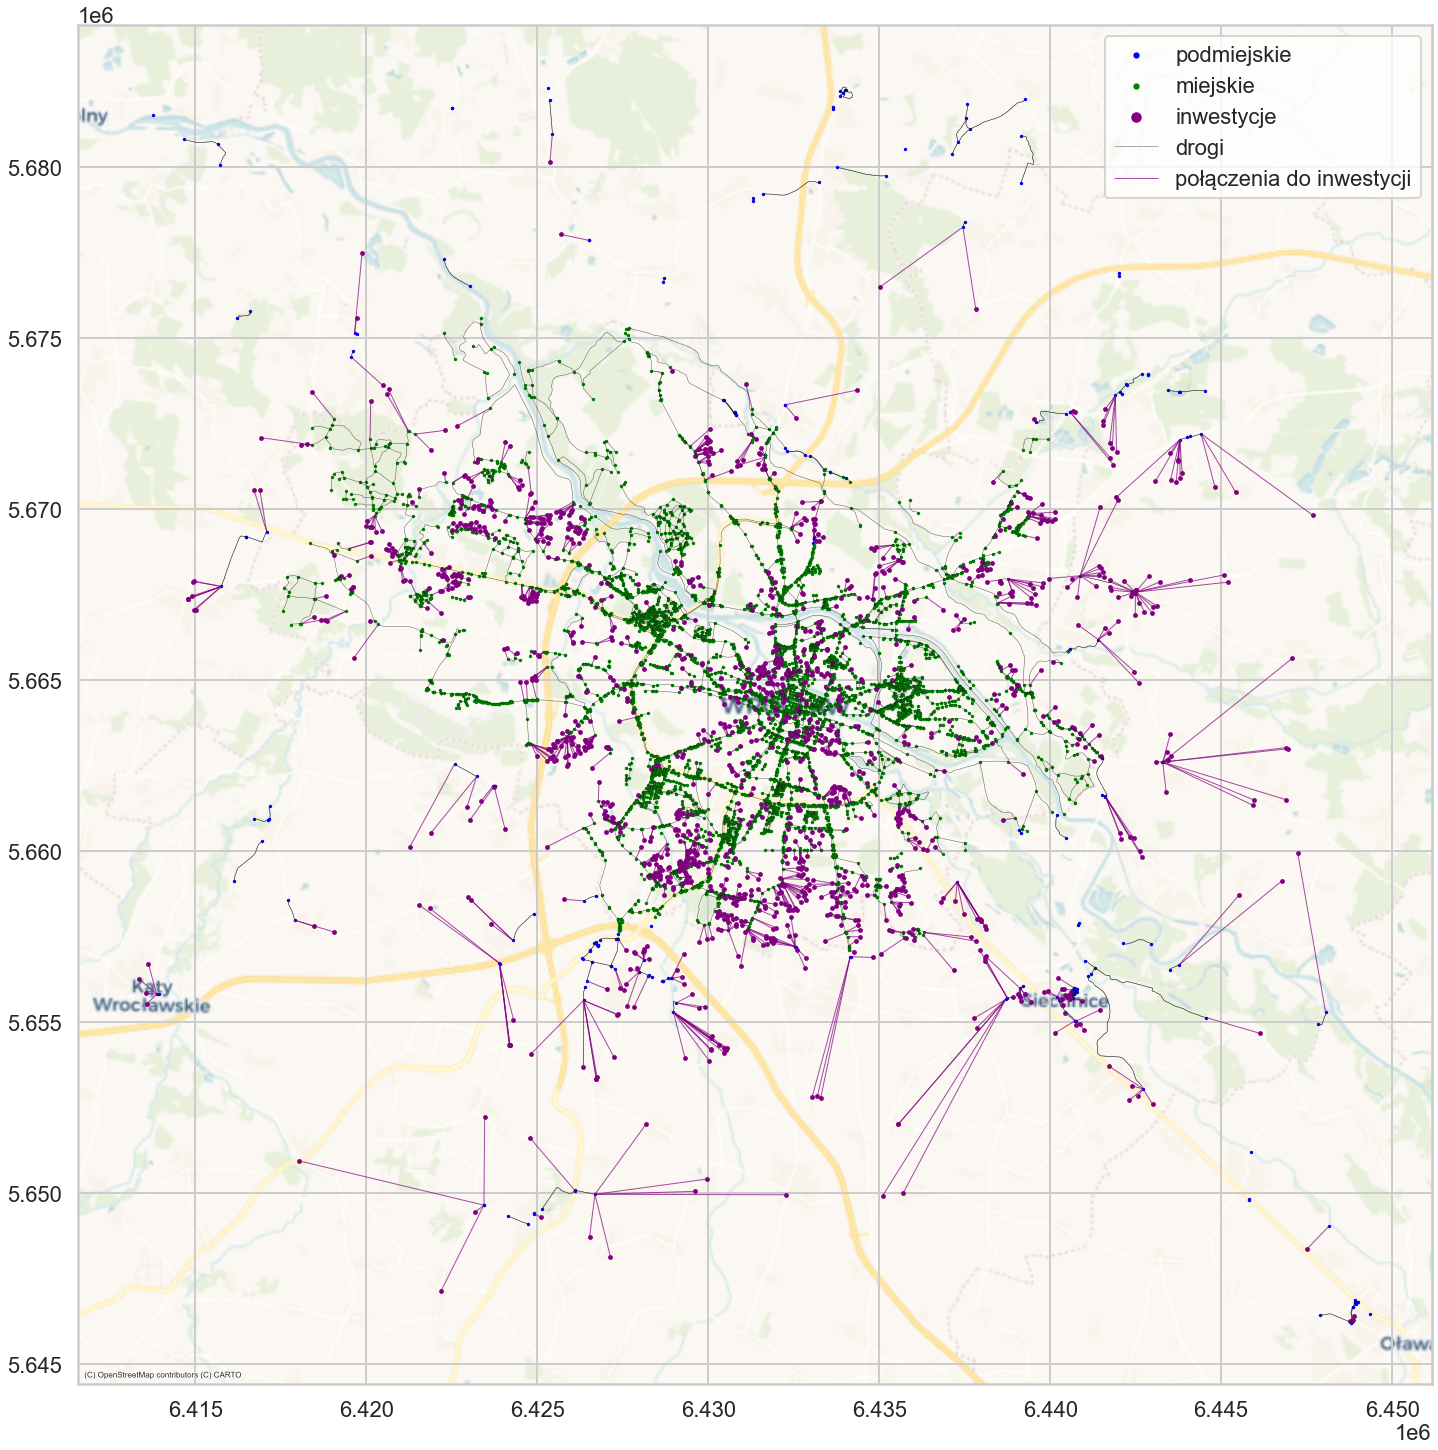

In [325]:
fig = plt.figure(figsize=(25, 25))
ax = plt.subplot()

G_nodes[G_nodes['type'] == 'peripheral_crossing'].plot(markersize=2, color='blue', ax=ax, legend=True)
G_nodes[G_nodes['type'] == 'city_crossing'].plot(markersize=2, color='green', ax=ax)
G_nodes[G_nodes['type'] == 'building'].plot(markersize=8, color='purple', ax=ax)

G_edges[G_edges['type'] == 'bicycle_path'].plot(ax=ax, alpha=0.7, linewidth=0.5, edgecolor='k')
G_edges[G_edges['type'] == 'closest_crossing'].plot(ax=ax, alpha=0.7, linewidth=1, edgecolor='purple')

cx.add_basemap(ax=ax, crs=G_nodes.crs.to_string(), source=cx.providers.CartoDB.Voyager)

ax.legend(['podmiejskie', 'miejskie', 'inwestycje', 'drogi', 'połączenia do inwestycji'], 
          loc='upper right', markerscale=3, framealpha=0.8)

In [326]:
fig.savefig('image\entire_with_investmap_dpi_200.png', bbox_inches='tight', dpi=200)

In [307]:
investamp_edges = G_edges[G_edges['type'] == 'closest_crossing']

In [308]:
investamp_edges.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 1480 entries, (371217955, '1320_building', 0) to (1006975, '13318_building', 0)
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   osmid      0 non-null      object  
 1   highway    0 non-null      object  
 2   oneway     0 non-null      object  
 3   length     1480 non-null   float64 
 4   geometry   1480 non-null   geometry
 5   type       1480 non-null   object  
 6   width      0 non-null      object  
 7   name       0 non-null      object  
 8   maxspeed   0 non-null      object  
 9   bridge     0 non-null      object  
 10  access     0 non-null      object  
 11  TYP        0 non-null      object  
 12  KIERUNEK   0 non-null      float64 
 13  SHAPE_LEN  0 non-null      float64 
 14  mm_len     0 non-null      float64 
dtypes: float64(4), geometry(1), object(10)
memory usage: 1.1+ MB


Text(0, 0.5, 'Liczność')

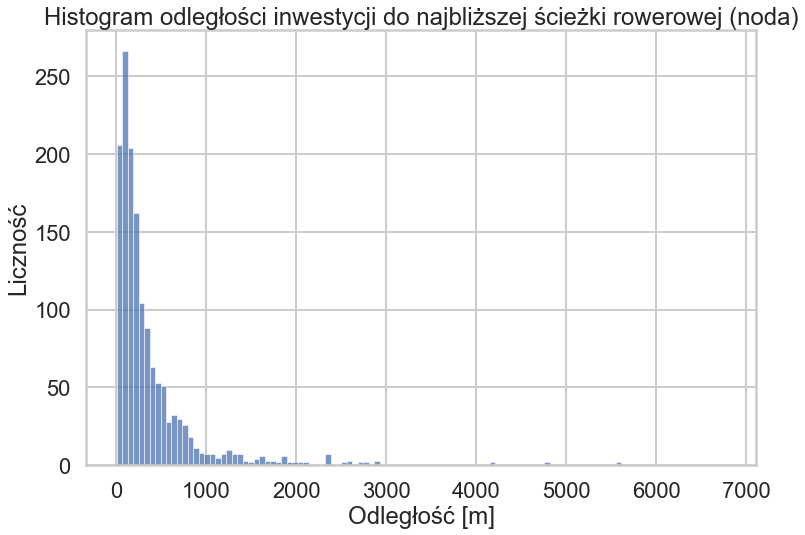

In [309]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(x='length', data=investamp_edges, ax=ax)
ax.set_title('Histogram odległości inwestycji do najbliższej ścieżki rowerowej (noda)')
ax.set_xlabel('Odległość [m]')
ax.set_ylabel('Liczność')

In [335]:
city_nodes = G_nodes[G_nodes['type']=='city_crossing'].reset_index()['osmid'].values

In [336]:
city_investamp_edges = investamp_edges.reset_index()
city_investamp_edges = city_investamp_edges.loc[city_investamp_edges['u'].isin(city_nodes)]

Text(0, 0.5, 'Liczność')

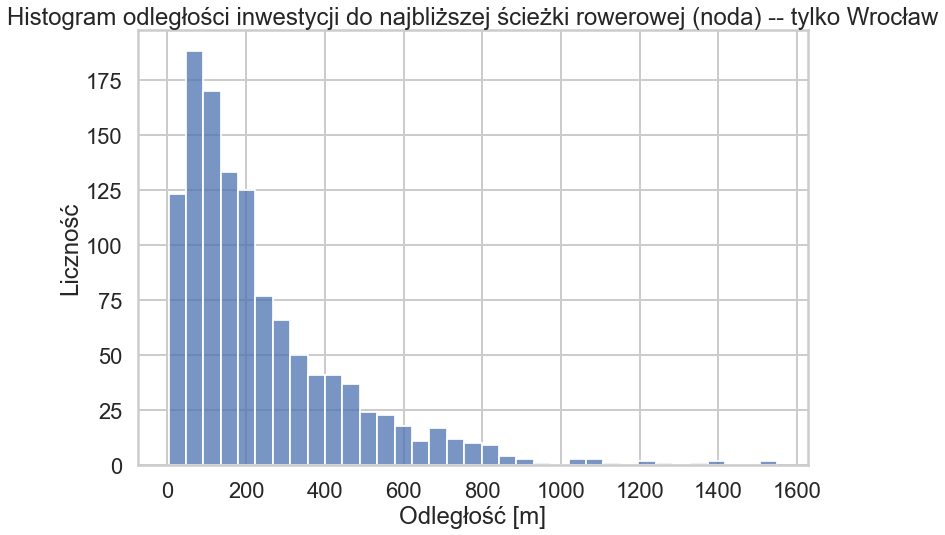

In [337]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(x='length', data=city_investamp_edges, ax=ax)
ax.set_title('Histogram odległości inwestycji do najbliższej ścieżki rowerowej (noda) -- tylko Wrocław')
ax.set_xlabel('Odległość [m]')
ax.set_ylabel('Liczność')